BOTNET DETECTION - DATA PREPROCESSING

[STEP 1] Loading Dataset...
✓ Dataset loaded successfully!
✓ Shape: (82332, 45)

[STEP 2] Dataset Overview...

First 5 rows:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  sttl  dttl        sload  dload  sloss  dloss  sinpkt  dinpkt  \
0   90909.0902   254     0  180363632.0    0.0      0      0   0.011     0.0   
1  125000.0003   254     0  881000000.0    0.0      0      0   0.008     0.0   
2  200000.0051   254     0  854400000.0    0.0      0      0   0.005     0.0   
3  166666.6608   254     0  600000000.0    0.0      0      0   0.006     0.0   
4  100000.0025   254 

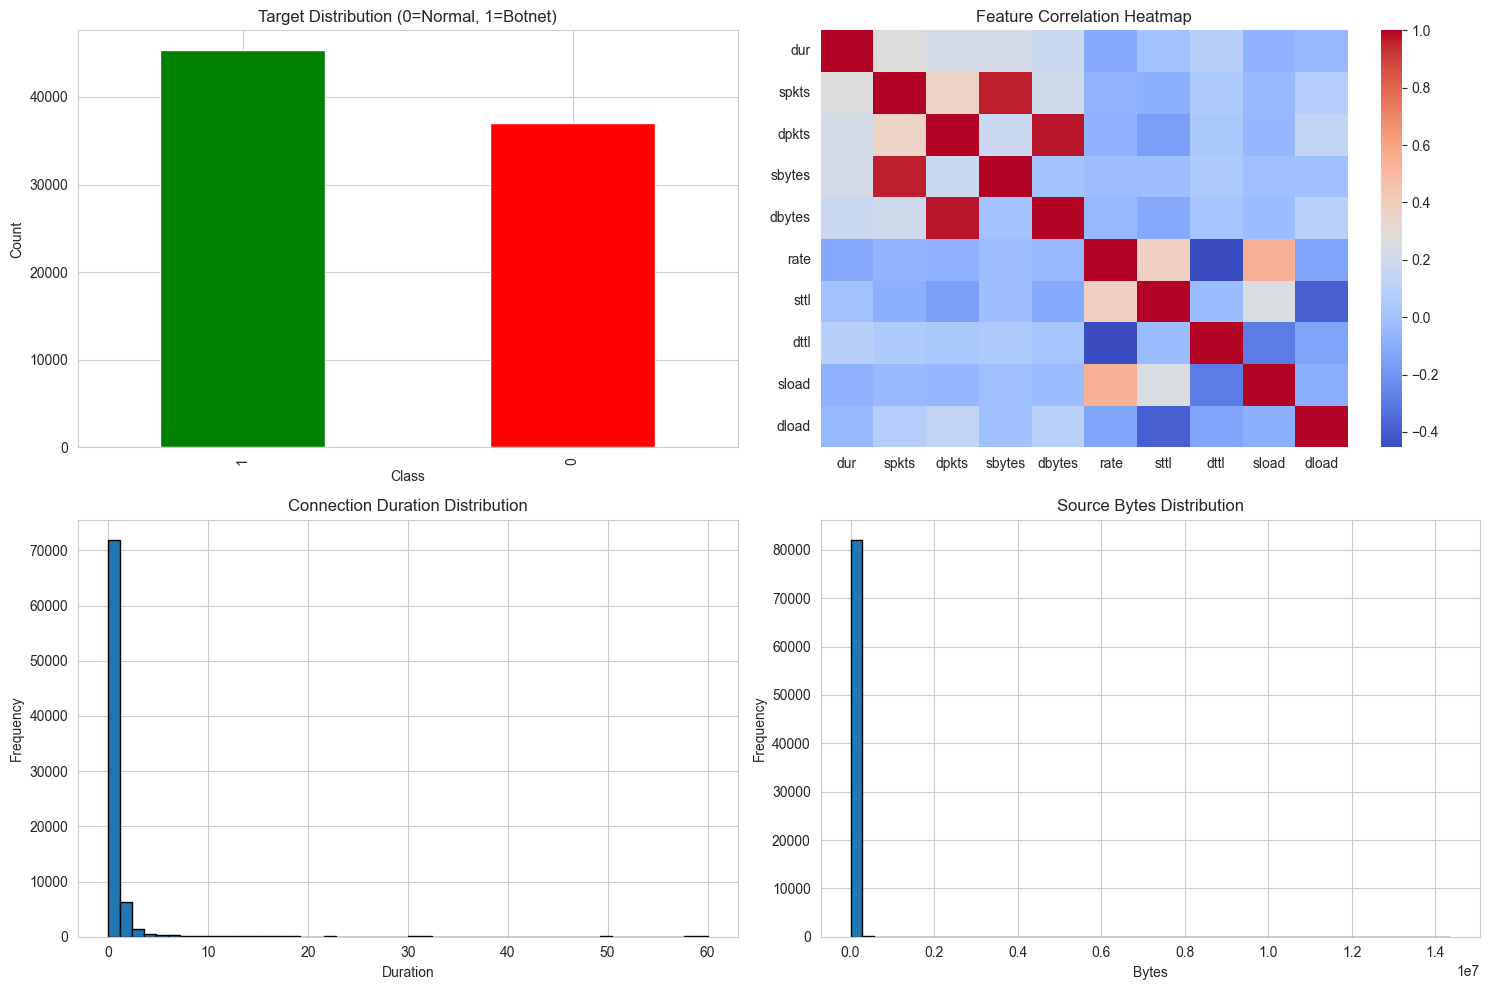


[STEP 8] Preparing Data for Machine Learning...
Features shape: (82332, 29)
Target shape: (82332,)
Target distribution:
label
1    45332
0    37000
Name: count, dtype: int64

Train set: (65865, 29)
Test set: (16467, 29)
✓ Features scaled using StandardScaler

[STEP 9] Saving Processed Data...
✓ Saved: X_train.npy, X_test.npy, y_train.npy, y_test.npy
✓ Saved: feature_names.pkl, scaler.pkl, label_encoders.pkl

DATA PREPROCESSING COMPLETED SUCCESSFULLY!

Next Steps:
1. Run the model training script (botnet_model_training.py)
2. The trained model will be saved as 'botnet_model.pkl'
3. Use the model in Flask application for predictions


In [8]:
# Botnet Detection - Data Preprocessing & Exploratory Data Analysis
# Save this as: botnet_preprocessing.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("=" * 60)
print("BOTNET DETECTION - DATA PREPROCESSING")
print("=" * 60)

# ========================================
# STEP 1: LOAD DATASET
# ========================================
print("\n[STEP 1] Loading Dataset...")

# For UNSW-NB15 Dataset
# Download from: https://research.unsw.edu.au/projects/unsw-nb15-dataset
# Or use this simplified version: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15

# If using local file:
try:
    df = pd.read_csv(r'archive (8)/UNSW_NB15_training-set.csv')  # Use raw string

    print(f"✓ Dataset loaded successfully!")
    print(f"✓ Shape: {df.shape}")
except FileNotFoundError:
    print("✗ Dataset not found!")
    print("Please download UNSW-NB15 dataset and place it in the same directory")
    print("Alternative: Download from Kaggle link mentioned above")
    # Creating sample data structure for demonstration
    print("\n[DEMO MODE] Creating sample data structure...")
    df = pd.DataFrame()

# ========================================
# STEP 2: EXPLORE DATASET
# ========================================
print("\n[STEP 2] Dataset Overview...")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nTarget Distribution:")
if 'label' in df.columns:
    print(df['label'].value_counts())
elif 'attack_cat' in df.columns:
    print(df['attack_cat'].value_counts())

# ========================================
# STEP 3: FEATURE SELECTION
# ========================================
print("\n[STEP 3] Feature Selection...")

# Key flow-based features for botnet detection
selected_features = [
    'dur',           # Connection duration
    'spkts',         # Source to destination packet count
    'dpkts',         # Destination to source packet count
    'sbytes',        # Source to destination bytes
    'dbytes',        # Destination to source bytes
    'rate',          # Rate (if available)
    'sttl',          # Source to destination time to live
    'dttl',          # Destination to source time to live
    'sload',         # Source bits per second
    'dload',         # Destination bits per second
    'sloss',         # Source packets retransmitted
    'dloss',         # Destination packets retransmitted
    'sinpkt',        # Source inter-packet arrival time
    'dinpkt',        # Destination inter-packet arrival time
    'sjit',          # Source jitter
    'djit',          # Destination jitter
    'swin',          # Source TCP window size
    'dwin',          # Destination TCP window size
    'stcpb',         # Source TCP base sequence number
    'dtcpb',         # Destination TCP base sequence number
    'tcprtt',        # TCP round trip time
    'synack',        # TCP SYN-ACK time
    'ackdat',        # TCP ACK-DAT time
    'proto',         # Protocol type
    'state',         # Connection state
    'service'        # Service type
]

# Filter features that exist in dataset
available_features = [f for f in selected_features if f in df.columns]
print(f"✓ Selected {len(available_features)} features from {len(df.columns)} total columns")

# ========================================
# STEP 4: DATA CLEANING
# ========================================
print("\n[STEP 4] Data Cleaning...")

# Create working dataframe with selected features + target
if 'label' in df.columns:
    target_col = 'label'
elif 'attack_cat' in df.columns:
    target_col = 'attack_cat'
    # Convert attack categories to binary (botnet vs normal)
    df['label'] = df[target_col].apply(lambda x: 0 if x == 'Normal' else 1)
    target_col = 'label'

df_clean = df[available_features + [target_col]].copy()

# Handle missing values
print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
df_clean = df_clean.fillna('unknown')
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

# Handle infinite values
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))

print(f"✓ Cleaned dataset shape: {df_clean.shape}")

# ========================================
# STEP 5: ENCODE CATEGORICAL FEATURES
# ========================================
print("\n[STEP 5] Encoding Categorical Features...")

categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    print(f"✓ Encoded: {col}")

# ========================================
# STEP 6: FEATURE ENGINEERING
# ========================================
print("\n[STEP 6] Feature Engineering...")

# Create additional flow-based features
if 'sbytes' in df_clean.columns and 'spkts' in df_clean.columns:
    df_clean['bytes_per_packet'] = df_clean['sbytes'] / (df_clean['spkts'] + 1)

if 'dur' in df_clean.columns and 'spkts' in df_clean.columns:
    df_clean['packets_per_second'] = df_clean['spkts'] / (df_clean['dur'] + 1)

if 'sbytes' in df_clean.columns and 'dbytes' in df_clean.columns:
    df_clean['byte_ratio'] = df_clean['sbytes'] / (df_clean['dbytes'] + 1)

print(f"✓ Added engineered features. New shape: {df_clean.shape}")

# ========================================
# STEP 7: VISUALIZATION
# ========================================
print("\n[STEP 7] Creating Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
if target_col in df_clean.columns:
    df_clean[target_col].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
    axes[0, 0].set_title('Target Distribution (0=Normal, 1=Botnet)')
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Count')

# Feature correlation heatmap (top 10 features)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns[:10]
sns.heatmap(df_clean[numeric_cols].corr(), annot=False, cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Feature Correlation Heatmap')

# Duration distribution
if 'dur' in df_clean.columns:
    df_clean['dur'].hist(bins=50, ax=axes[1, 0], edgecolor='black')
    axes[1, 0].set_title('Connection Duration Distribution')
    axes[1, 0].set_xlabel('Duration')
    axes[1, 0].set_ylabel('Frequency')

# Bytes distribution
if 'sbytes' in df_clean.columns:
    df_clean['sbytes'].hist(bins=50, ax=axes[1, 1], edgecolor='black')
    axes[1, 1].set_title('Source Bytes Distribution')
    axes[1, 1].set_xlabel('Bytes')
    axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("✓ Visualizations saved as 'eda_visualizations.png'")
plt.show()

# ========================================
# STEP 8: PREPARE DATA FOR ML
# ========================================

# ========================================
# STEP 8: PREPARING DATA FOR MACHINE LEARNING
# ========================================
print("\n[STEP 8] Preparing Data for Machine Learning...")

# Separate features and target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# 🔹 Ensure all features are numeric (important fix for 'tcp' error)
non_numeric = X.select_dtypes(include=['object']).columns
if len(non_numeric) > 0:
    print(f"\n[INFO] Found non-numeric columns: {list(non_numeric)}")
    print("Encoding them with LabelEncoder...")
    for col in non_numeric:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    print("✓ All non-numeric columns encoded successfully!")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")


# ========================================
# STEP 9: SAVE PROCESSED DATA
# ========================================
print("\n[STEP 9] Saving Processed Data...")

# Save processed data
np.save('X_train.npy', X_train_scaled)
np.save('X_test.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# Save feature names and scaler
import pickle
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("✓ Saved: X_train.npy, X_test.npy, y_train.npy, y_test.npy")
print("✓ Saved: feature_names.pkl, scaler.pkl, label_encoders.pkl")

print("\n" + "=" * 60)
print("DATA PREPROCESSING COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("\nNext Steps:")
print("1. Run the model training script (botnet_model_training.py)")
print("2. The trained model will be saved as 'botnet_model.pkl'")
print("3. Use the model in Flask application for predictions")